# **1. Import các thư viện quan trọng**


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
!pip install catboost
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [60]:
import os
for dirname, _, filenames in os.walk('/content/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **2. Load Dataset**

In [61]:
train_data_path = "./train.csv"
test_data_path = "./test.csv"
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path, index_col='Id')

In [62]:
# Đối với việc submit trên Kaggle

submission_data_path = "./sample_submission.csv"
submission = pd.read_csv(submission_data_path)

# **3. Phân tích dữ liệu với EDA**

### 3.1. Kiểm tra kích thước data

In [63]:
train.shape

(1642, 10)

In [64]:
test.shape

(411, 9)

### 3.2. Kiểm tra kiểu dữ liệu của từng feature trong data

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [66]:
train.dtypes

,0
model,object
year,int64
motor_type,object
running,object
wheel,object
color,object
type,object
status,object
motor_volume,float64
price,int64


### 3.3. Kiểm tra dữ liệu của từng feature

In [67]:
train.head(10)

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
5,mercedes-benz,2001,petrol,286293 km,left,blue,sedan,good,1.8,6000
6,nissan,2019,petrol,49000 miles,left,gray,suv,excellent,2.0,23200
7,nissan,2018,petrol,70000 miles,left,silver,suv,excellent,2.5,19800
8,mercedes-benz,2019,petrol,85000 km,left,black,sedan,excellent,2.0,7000
9,hyundai,2021,petrol,58000 miles,left,silver,sedan,crashed,2.0,13900


- Kiểm tra tập train và tập test có chứa dữ liệu NaN hay không.

In [68]:
train.isna().sum()

,0
model,0
year,0
motor_type,0
running,0
wheel,0
color,0
type,0
status,0
motor_volume,0
price,0


- Kiểm tra dữ liệu trong tập train có bị lặp lại hay không.

In [69]:
train.duplicated().sum()
train[train.duplicated()]

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
500,toyota,2014,petrol,42000 miles,left,silver,sedan,excellent,1.8,16000
917,nissan,2019,petrol,49000 miles,left,gray,suv,excellent,2.0,23200
918,kia,2020,petrol,60000 miles,left,silver,sedan,excellent,2.0,19000
922,mercedes-benz,2007,petrol and gas,280000 km,left,black,sedan,good,2.0,12000
1137,kia,2020,petrol,60000 miles,left,silver,sedan,excellent,2.0,19000
1198,hyundai,2018,petrol,90000 miles,left,black,sedan,excellent,2.0,12500
1477,hyundai,2019,petrol,75000 miles,left,black,sedan,excellent,2.0,15500
1543,hyundai,2022,petrol,5000 km,left,black,sedan,excellent,2.0,15750
1581,hyundai,2020,petrol,128000 km,left,white,sedan,excellent,2.0,14500


In [70]:
train.duplicated().any().any()

np.True_

### 3.4. Phân tích dữ liệu

#### 3.4.1. Phân tích sự phân phối dữ liệu (Data distribution)


- Phân tích sự phân phối dữ liệu thông qua thống kê của tập train.

In [71]:
train.describe()

,year,motor_volume,price
count,1642.000000,1642.000000,1642.000000
mean,2014.805725,2.035018,15982.633374
std,6.587573,0.253069,7176.084647
min,1987.000000,0.200000,462.000000
25%,2013.000000,2.000000,12000.000000
50%,2017.000000,2.000000,15750.000000
75%,2019.000000,2.000000,18500.000000
max,2023.000000,4.000000,87000.000000


- Ngoài ra, ta phân tích sự phân phối dữ liệu bằng Histogram.

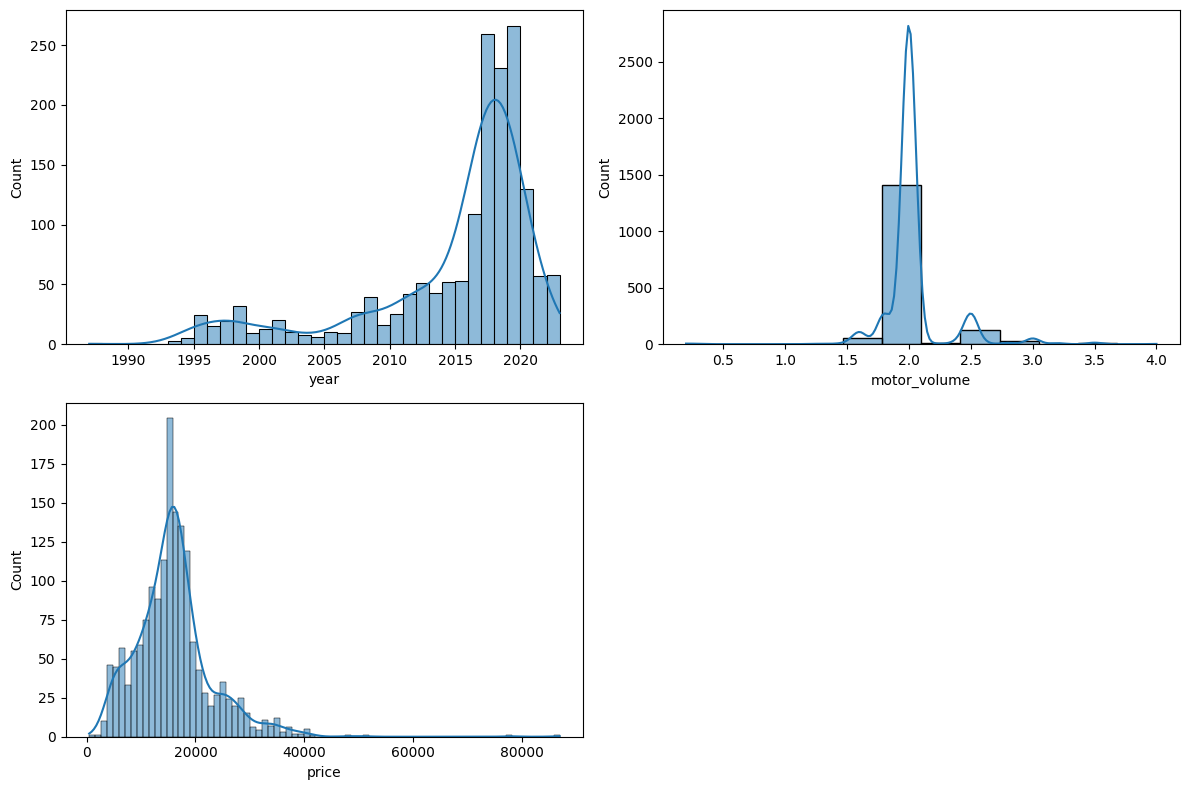

In [72]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, (len(numeric_cols) + 1) // 2, i)
    sns.histplot(train[col], kde=True)
plt.tight_layout()
plt.show()

#### 3.4.2. Phân tích dữ liệu ngoại lệ (outlier)

- Ta áp dụng phương pháp **IQR (Interquartile Range)** để phân tích dữ liệu ngoại lệ, thông qua biểu đồ Boxplot.

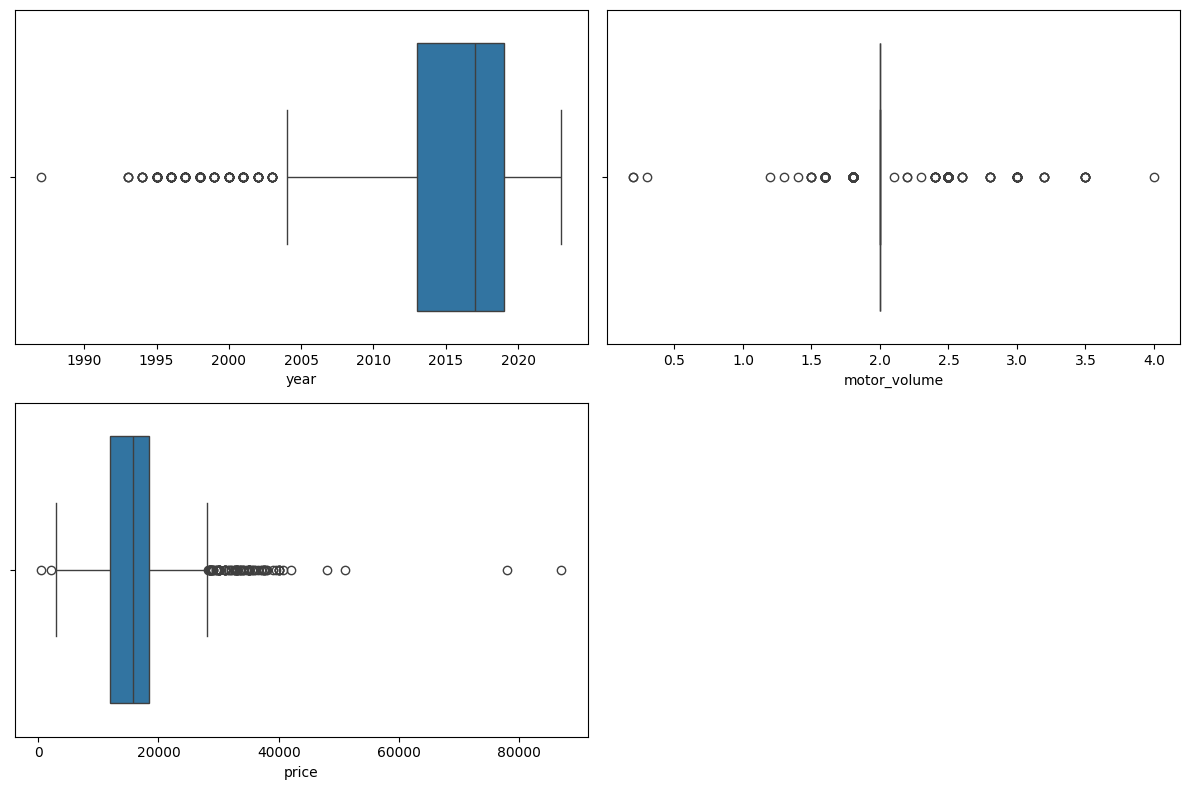

In [73]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, (len(numeric_cols) + 1) // 2, i)
    sns.boxplot(x=train[col])

plt.tight_layout()
plt.show()

- Có thể thấy, cột 'price' đang có nhiều giá trị ngoại lệ nhất.

#### 3.4.3. Phân tích đơn biến

- Để phân tích đơn biến, ta sử dụng countplot.

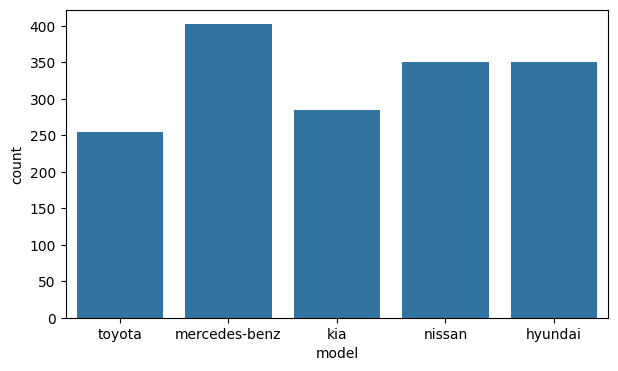

In [74]:
plt.figure(figsize=(7, 4))
sns.countplot(data=train, x='model')
plt.show()

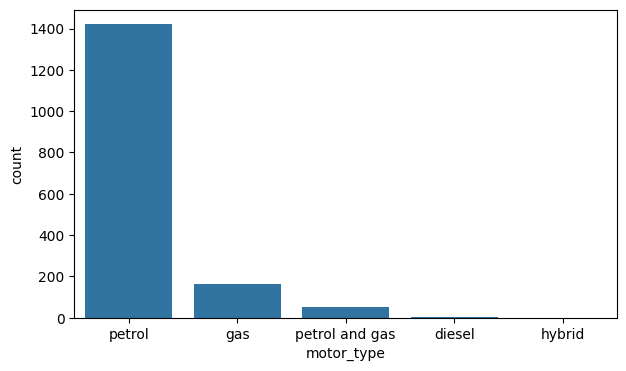

In [75]:
plt.figure(figsize=(7, 4))
sns.countplot(data=train, x='motor_type')
plt.show()

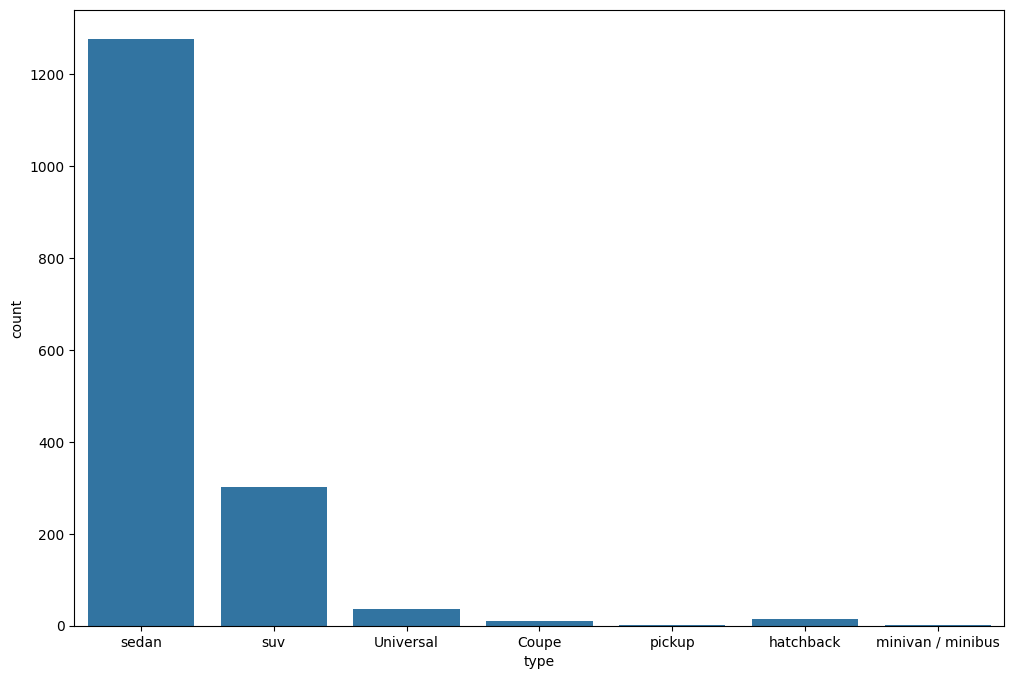

In [76]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x='type')
plt.show()

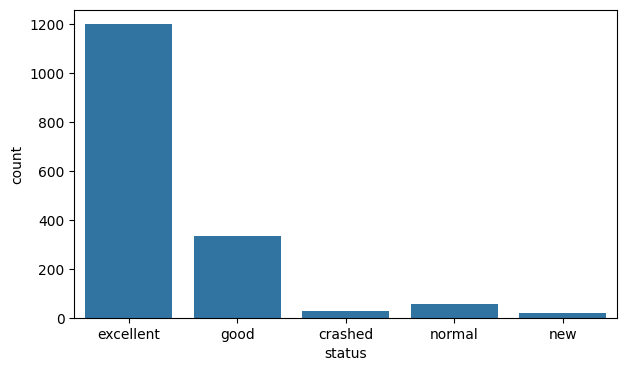

In [77]:
plt.figure(figsize=(7, 4))
sns.countplot(data=train, x='status')
plt.show()

#### 3.4.4. Phân tích đa biến

- **Feature - Feature**: Ta sẽ áp dụng Heatmap để phân tích đa biến giữa Feature với Feature.

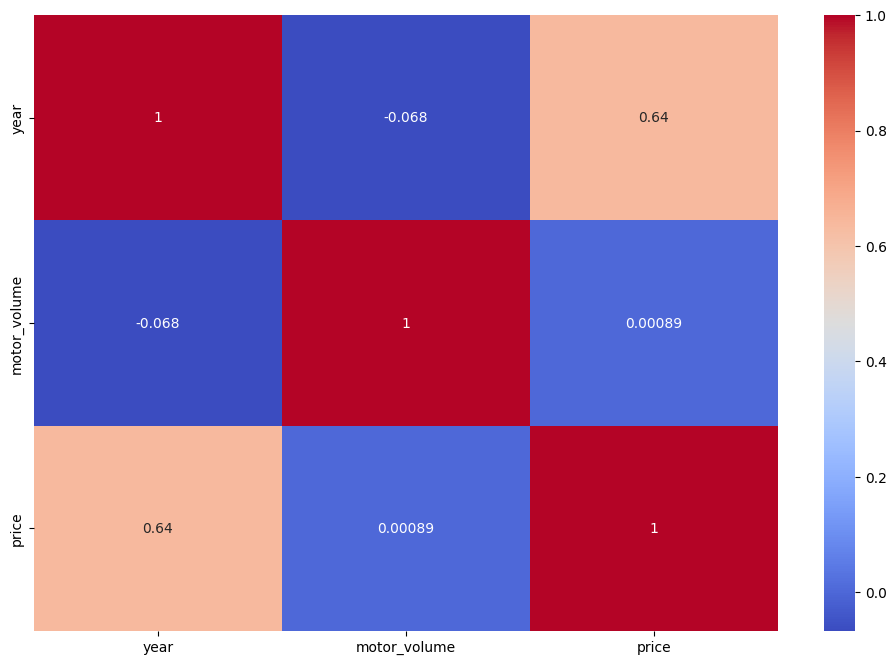

In [78]:
numeric_cols = train.select_dtypes(exclude='object').columns

plt.figure(figsize=(12, 8))
sns.heatmap(data=train[numeric_cols].corr(), annot=True, cmap='coolwarm')

plt.show()

- **Feature - Label**: Ta sẽ dùng pairplot trong việc phân tích đa biến giữa Feature với Label.

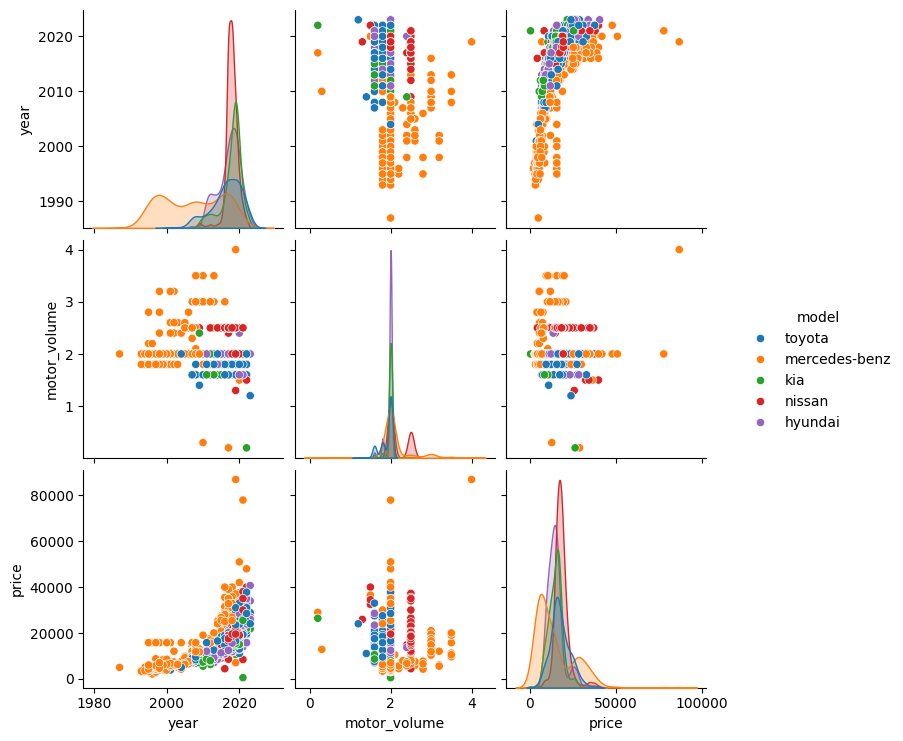

In [79]:
sns.pairplot(data=train, hue='model')

# **4. Tiền xử lý dữ liệu**

### 4.1. Chiến thuật xử lý dữ liệu ngoại lệ (outlier)

- Các mô hình Catboost và XGBoost ít nhạy cảm với outlier nên giá trị dự đoán không bị kéo lệch.
- Giữ lại outlier để mô tả toàn diện bộ dữ liệu, cần biết tình trạng thị trường thực tế.

### 4.2. Chiến thuật xử lý dữ liệu bị khuyết (NaN values)

- Bộ dữ liệu này không có giá trị NaN. Tuy nhiên, ta sẽ sử dụng sklearn-imputation để xử lý các giá trị NaN nếu có.

In [80]:
category_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()

imputer_mean = SimpleImputer(strategy='mean')
train[numeric_cols] = imputer_mean.fit_transform(train[numeric_cols])

imputer_mode = SimpleImputer(strategy='most_frequent')
train[category_cols] = imputer_mode.fit_transform(train[category_cols])

train.isnull().sum()

,0
model,0
year,0
motor_type,0
running,0
wheel,0
color,0
type,0
status,0
motor_volume,0
price,0


### 4.3. Chiến thuật encode dữ liệu

- Trước hết ta convert running column thành running_km column.

<Axes: xlabel='running_km', ylabel='Count'>

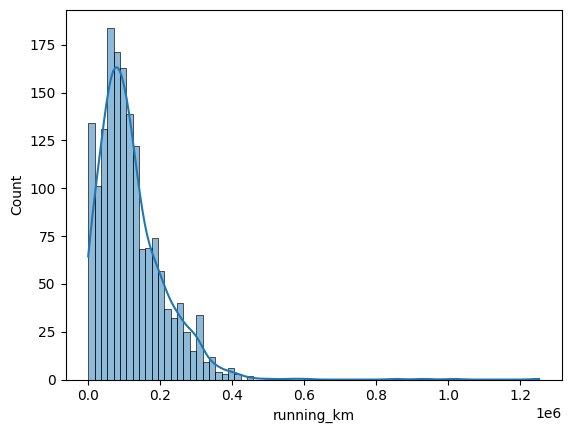

In [81]:
def convert_to_km(dist):
  val, unit = re.match(r'(\d+)\s*([a-zA-Z]+)', dist).groups()
  if unit.lower() == 'miles':
    return float(val) * 1.60934
  else:
    return float(val)

train['running_km'] = train['running'].apply(convert_to_km)
test['running_km'] = train['running'].apply(convert_to_km)
sns.histplot(train['running_km'], kde=True)

In [82]:
train.drop_duplicates(inplace=True, keep='first')
train.shape

(1633, 11)

- Ta sẽ sử dụng LabelEncoder từ sklearn.preprocessing để encode dữ liệu.

In [83]:
label_encoder = LabelEncoder()

for col in category_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])

In [84]:
train.head(10)

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price,running_km
0,4,2022.0,3,314,0,15,5,1,2.0,24500.0,3000.00
1,2,2014.0,3,93,0,1,5,1,2.0,25500.0,132000.00
2,1,2018.0,3,627,0,10,5,1,2.0,11700.0,152887.30
3,2,2002.0,3,104,0,6,5,1,3.2,12000.0,220479.58
4,2,2017.0,3,89,0,1,5,2,2.0,26000.0,130000.00
5,2,2001.0,3,301,0,2,5,2,1.8,6000.0,286293.00
6,3,2019.0,3,433,0,7,6,1,2.0,23200.0,78857.66
7,3,2018.0,3,533,0,14,6,1,2.5,19800.0,112653.80
8,2,2019.0,3,589,0,1,5,1,2.0,7000.0,85000.00
9,0,2021.0,3,475,0,14,5,0,2.0,13900.0,93341.72


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 0 to 1641
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1633 non-null   int64  
 1   year          1633 non-null   float64
 2   motor_type    1633 non-null   int64  
 3   running       1633 non-null   int64  
 4   wheel         1633 non-null   int64  
 5   color         1633 non-null   int64  
 6   type          1633 non-null   int64  
 7   status        1633 non-null   int64  
 8   motor_volume  1633 non-null   float64
 9   price         1633 non-null   float64
 10  running_km    1633 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 153.1 KB


In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 0 to 410
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         411 non-null    int64  
 1   year          411 non-null    int64  
 2   motor_type    411 non-null    int64  
 3   running       411 non-null    int64  
 4   wheel         411 non-null    int64  
 5   color         411 non-null    int64  
 6   type          411 non-null    int64  
 7   status        411 non-null    int64  
 8   motor_volume  411 non-null    float64
 9   running_km    411 non-null    float64
dtypes: float64(2), int64(8)
memory usage: 35.3 KB


### 4.4. Feature Engineering (pre-version)

- Ta thêm cột 'running_per_year' thể hiện số km chạy được mỗi năm.

In [87]:
train['run_per_year'] = train['running_km'] / (2025-train['year'])
test['run_per_year'] = test['running_km'] / (2025-test['year'])
print(train[['running_km','year','run_per_year']])

      running_km    year  run_per_year
0       3000.000  2022.0   1000.000000
1     132000.000  2014.0  12000.000000
2     152887.300  2018.0  21841.042857
3     220479.580  2002.0   9586.068696
4     130000.000  2017.0  16250.000000
...          ...     ...           ...
1637  193120.800  2017.0  24140.100000
1638  170000.000  2014.0  15454.545455
1639  110883.526  2018.0  15840.503714
1640   49889.540  2019.0   8314.923333
1641      20.000  2022.0      6.666667

[1633 rows x 3 columns]


### 4.5. Chiến thuật chuẩn hoá dữ liệu (Normalization)

# **5. Feature Engineering**

### 5.1. Loại bỏ các đặc trưng không có nhiều giá trị dự đoán

Xóa cột running và giữ lại cột running_km vì cột running không đồng nhất đơn vị nên ta chuyển về chung một đơn vị ở cột running_km.

In [88]:
train.drop(columns=['running'], inplace=True)
test.drop(columns=['running'], inplace=True)

Loại bỏ cột wheel vì cột wheel chỉ mang 1 giá trị --> Không có ý nghĩa cho việc dự đoán

In [89]:
train.drop(columns=['wheel'], inplace=True)
test.drop(columns=['wheel'], inplace=True)

### 5.2. Tạo mới đặc trưng

Tạo thêm feature running_per_year.


In [90]:
train['run_per_year'] = train['running_km'] / (2025-train['year'])
test['run_per_year'] = test['running_km'] / (2025-test['year'])
print(train[['running_km','year','run_per_year']])

      running_km    year  run_per_year
0       3000.000  2022.0   1000.000000
1     132000.000  2014.0  12000.000000
2     152887.300  2018.0  21841.042857
3     220479.580  2002.0   9586.068696
4     130000.000  2017.0  16250.000000
...          ...     ...           ...
1637  193120.800  2017.0  24140.100000
1638  170000.000  2014.0  15454.545455
1639  110883.526  2018.0  15840.503714
1640   49889.540  2019.0   8314.923333
1641      20.000  2022.0      6.666667

[1633 rows x 3 columns]


Giá trị running_per_year cao hơn cho biết xe đã được sử dụng nhiều hơn mỗi năm, điều này có thể cho thấy mức độ hao mòn cao hơn.
Giá trị running_per_year thấp hơn cho biết mức độ sử dụng ít hơn, điều này có thể cho thấy mức độ bảo dưỡng tốt hơn và có khả năng giá trị bán lại cao hơn.
→ Đặc trưng này năng này giúp nắm bắt mối quan hệ giữa tuổi của xe và mức độ sử dụng của xe, đây có thể là yếu tố quan trọng trong việc xác định giá của xe.

### 5.3. Chọn Encoding phù hợp

Do sử dụng model dựa trên cây quyết định nên chọn label encoding thay vì one-hot encoding sẽ tạo ra nhiều cột feature hơn.

Vì ở phần 4.3, ta đã sử dụng LabelEncoder để encode các dữ liệu rồi nên ta bỏ qua phần này.

### 5.4. Chọn lựa đặc trưng

Chọn đặc trưng vào correlation_matrix. Nếu đặc trưng nào có độ tương quan cao (> 0.9) thì loại bỏ.

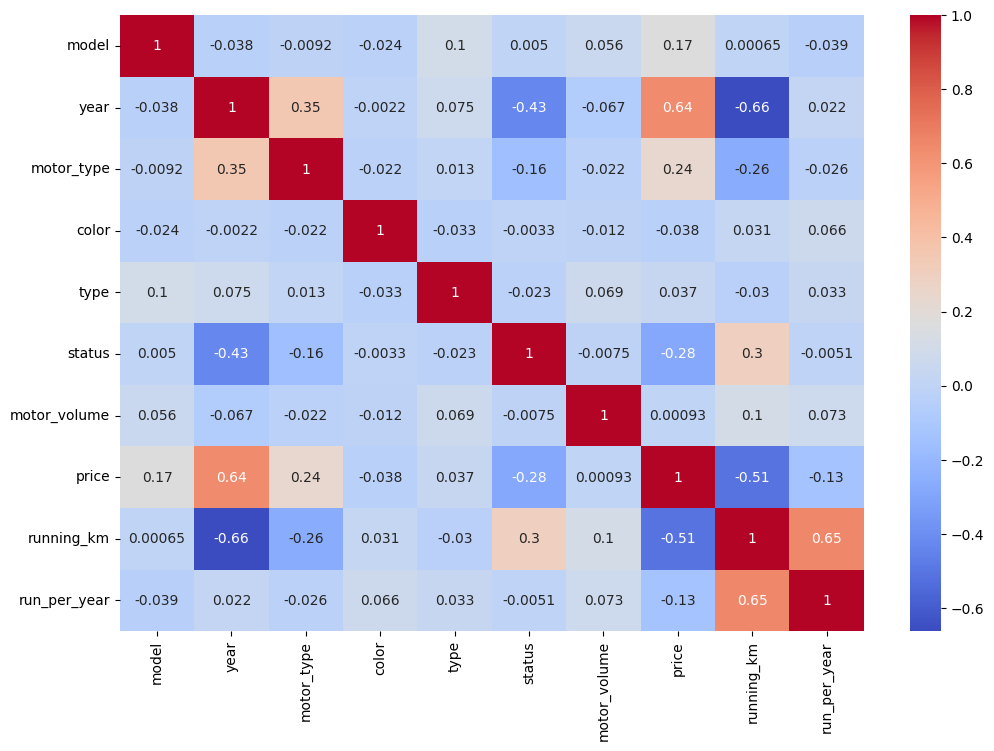

In [91]:
correlation_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(data=train.corr(), annot=True, cmap='coolwarm')
plt.show()

Dùng model-based method

In [92]:
X = train.drop(columns=['price'], axis=1)
y = train['price']

In [93]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_features = feature_importances.head(10)

print(top_features)
X.drop(columns=['motor_type'], inplace=True)

        Feature  Importance
1          year    0.539081
0         model    0.224644
7    running_km    0.061097
6  motor_volume    0.056952
8  run_per_year    0.050471
5        status    0.030933
3         color    0.021651
4          type    0.011559
2    motor_type    0.003612


Recursive Feature Elimination (RFE): Loại từng feature yếu nhất rồi train lại.

In [94]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print(selected_features)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


Index(['model', 'year', 'color', 'type', 'status', 'motor_volume',
       'running_km', 'run_per_year'],
      dtype='object')


# **6. Modeling Data**

Trước hết, ta sẽ chia tập huấn luyện X, y, theo tỉ lệ 80:20.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **6.1. Sử dụng model CatBoost**

*CatBoost (Categorical Boosting)* là một khuôn khổ tăng cường gradient, mã nguồn mở, hiệu suất cao do Yandex phát triển. Nó được thiết kế để giải quyết nhiều tác vụ học máy, bao gồm phân loại, hồi quy và xếp hạng, đặc biệt chú trọng vào việc xử lý các tính năng phân loại một cách hiệu quả. Catboost nổi bật với tốc độ, độ chính xác và dễ sử dụng khi xử lý dữ liệu có cấu trúc.

Chính vì vậy, CatBoost là 1 trong các model lý tưởng để áp dụng đánh giá dataset này.

In [129]:
category_cols = [c for c in category_cols if c in X_train.columns]

cat_model = CatBoostRegressor(loss_function='MAE', verbose=0, iterations=1200, random_state=42, cat_features=category_cols)

train_pool = Pool(data=X_train, label=y_train, cat_features=category_cols)
eval_pool = Pool(data=X_test, label=y_test, cat_features=category_cols)

cat_model.fit(train_pool, eval_set=eval_pool, use_best_model=True)

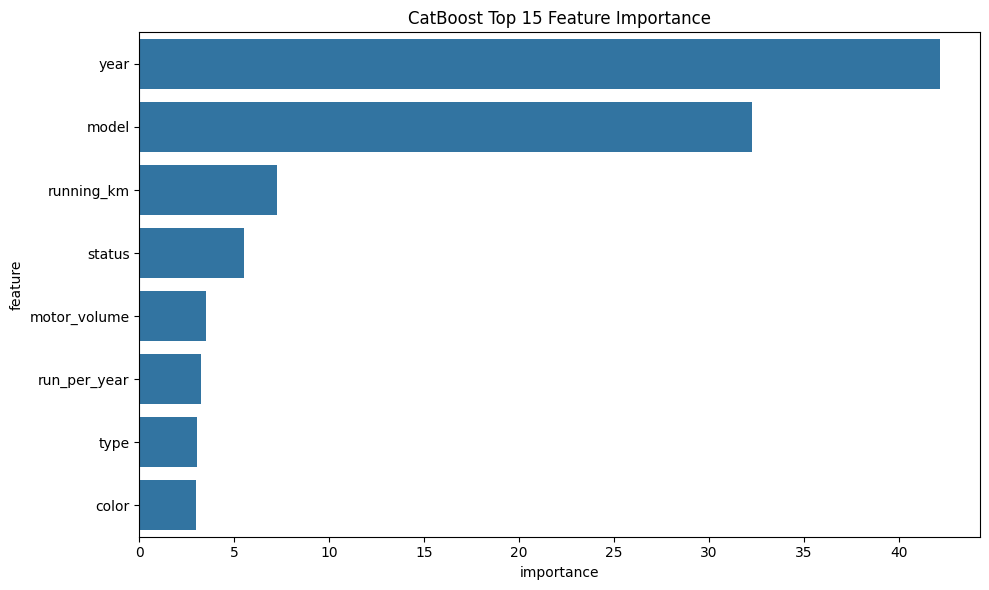

In [108]:
fi = pd.DataFrame({'feature': X_train.columns, 'importance': cat_model.get_feature_importance(train_pool)}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi.head(15))
plt.title('CatBoost Top 15 Feature Importance')
plt.tight_layout()

plt.show()

In [109]:
y_pred_cat = cat_model.predict(X_test)
mae_cat = mean_absolute_error(y_test, y_pred_cat)

print(f"CatBoost MAE: {mae_cat:.4f}")

CatBoost MAE: 1846.8110


In [110]:
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))

print(f"CatBoost RMSE: {rmse_cat:.4f}")

CatBoost RMSE: 3199.2004


### **6.2. Sử dụng model XGBoost**

*XGBoost (Extreme Gradient Boosting)* là một triển khai được tối ưu hóa của Gradient Boosting và là một loại phương pháp học tập tổng hợp. Học tập tổng hợp kết hợp nhiều mô hình yếu để tạo thành một mô hình mạnh hơn.

XGBoost sử dụng cây quyết định làm trình học cơ sở, kết hợp chúng theo trình tự để cải thiện hiệu suất của mô hình. Mỗi cây mới được đào tạo để sửa lỗi do cây trước đó tạo ra và quá trình này được gọi là tăng cường.

Nó có xử lý song song tích hợp để đào tạo các mô hình trên các tập dữ liệu lớn một cách nhanh chóng. XGBoost cũng hỗ trợ tùy chỉnh cho phép người dùng điều chỉnh các tham số mô hình để tối ưu hóa hiệu suất dựa trên vấn đề cụ thể.

In [118]:
params_xgb = {'booster': 'gbtree',
          'max_depth': 3,
          'max_leaves': 769,
          'learning_rate': 0.04538451353216046,
          'n_estimators': 1171,
          'min_child_weight': 13,
          'subsample': 0.6578720167306904,
          'reg_alpha': 0.4622943878867952,
          'reg_lambda': 0.6211309481623339,
          'colsample_bylevel': 0.7985625445322192,
          'colsample_bytree': 0.9634723040072963,
          'colsample_bynode': 0.49814271378837316,
          'objective': 'reg:absoluteerror',
          'n_jobs': -1,
          'random_state': 42
         }

xgb_model = XGBRegressor(**params_xgb)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7985625445322192,
             colsample_bynode=0.49814271378837316,
             colsample_bytree=0.9634723040072963, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04538451353216046, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=769,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1171, n_jobs=-1,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

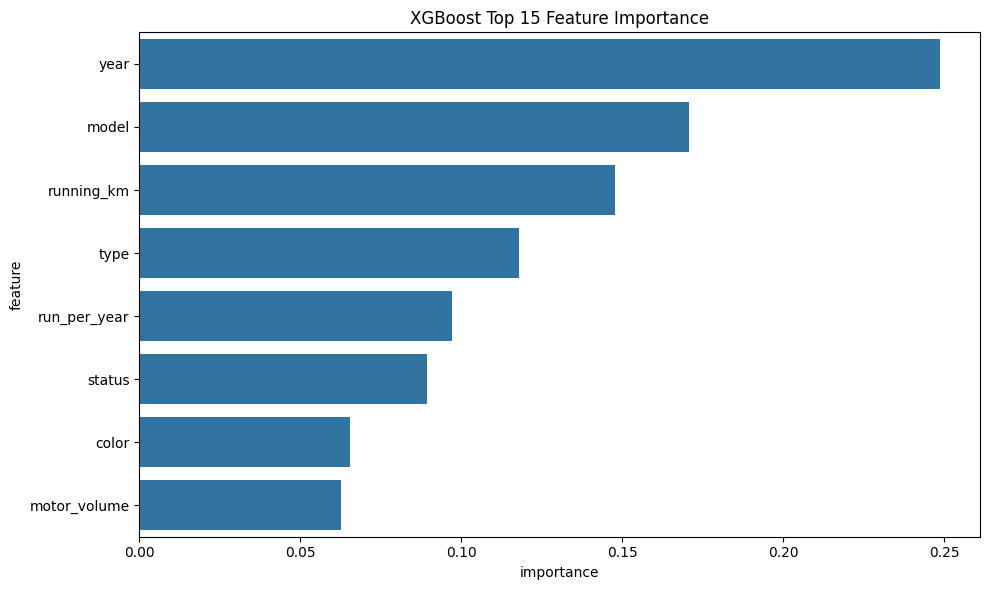

In [119]:
fi_xgb = pd.DataFrame({'feature': X_train.columns, 'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi_xgb.head(15))
plt.title('XGBoost Top 15 Feature Importance')
plt.tight_layout()

plt.show()

In [120]:
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.4f}")

XGBoost MAE: 1903.0657


In [121]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost RMSE: {rmse_xgb:.4f}")

XGBoost RMSE: 3296.6259


### **6.3. Sử dụng kết hợp XGBoost+CatBoost**

Ta sẽ kết hợp XGBoost + CatBoost theo tỉ trọng 35:65, đưa ra chỉ số MAE cùng với RMSE.

In [125]:
y_pred_ens = y_pred_xgb*0.35 + y_pred_cat*0.65
mae_ens = mean_absolute_error(y_test, y_pred_ens)

print(f"Ensemble MAE (XGBoost+CatBoost): {mae_ens:.4f}")

Ensemble MAE (XGBoost+CatBoost): 1844.0081


In [126]:
rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ens))

print(f"Ensemble RMSE (XGBoost+CatBoost): {rmse_ens:.4f}")

Ensemble RMSE (XGBoost+CatBoost): 3202.6772


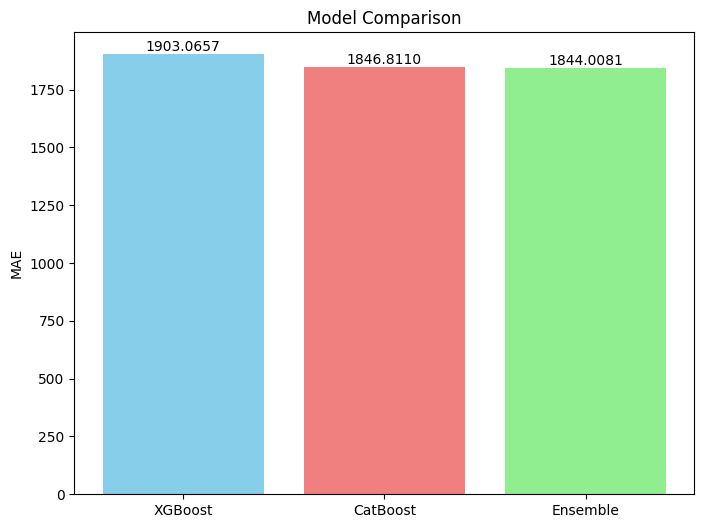

In [127]:
mae_scores = {
    'XGBoost': mae_xgb,
    'CatBoost': mae_cat,
    'Ensemble': mae_ens
}

models = list(mae_scores.keys())
mae_values = list(mae_scores.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(models, mae_values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('MAE')
plt.title('Model Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()